<a href="https://colab.research.google.com/github/allenlu2009/tensorflow2/blob/master/rnn_sin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
print(sys.version)
import tensorflow
print(tensorflow.__version__)
import keras
print(keras.__version__)

import pandas as pd
import numpy as np
import math

import random
import matplotlib.pyplot as plt
%matplotlib inline

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


1.15.0
2.2.5


Using TensorFlow backend.


#Generate a sin wave with no noise
First, I create a function that generates sin wave with/without noise. Using this function, I will generate a sin wave with no noise. As this sin wave is completely deterministic, I should be able to create a model that can do prefect prediction the next value of sin wave given the previous values of sin waves!

Here I generate period-10 sin wave, repeating itself 500 times, and plot the first few cycles.

create period-10 sin wave with 500 cycles
In total, the sin wave time series length is 5001


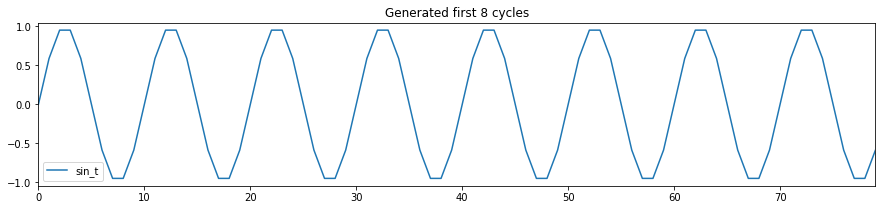

In [0]:
def noisy_sin(steps_per_cycle = 50,
              number_of_cycles = 500,
              random_factor = 0.4):
    '''
    number_of_cycles : The number of steps required for one cycle
    
    Return : 
    pd.DataFrame() with column sin_t containing the generated sin wave 
    '''
    random.seed(0)
    df = pd.DataFrame(np.arange(steps_per_cycle * number_of_cycles + 1), columns=["t"])
    df["sin_t"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
    df["sin_t_clean"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)))
    print("create period-{} sin wave with {} cycles".format(steps_per_cycle,number_of_cycles))
    print("In total, the sin wave time series length is {}".format(steps_per_cycle*number_of_cycles+1))
    return(df)



steps_per_cycle = 10
df = noisy_sin(steps_per_cycle=steps_per_cycle,
              random_factor = 0)

n_plot = 8
df[["sin_t"]].head(steps_per_cycle * n_plot).plot(
      title="Generated first {} cycles".format(n_plot),
      figsize=(15,3))

Create a training and testing data. Here, the controversial "length of time series" parameter comes into play. For now, we set this parameter to 2.

In [0]:
def _load_data(data, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

length_of_sequences = 2
test_size = 0.25
ntr = int(len(df) * (1 - test_size))
df_train = df[["sin_t"]].iloc[:ntr]
df_test  = df[["sin_t"]].iloc[ntr:]
(X_train, y_train) = _load_data(df_train, n_prev = length_of_sequences)
(X_test, y_test)   = _load_data(df_test, n_prev = length_of_sequences)  
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


(3748, 2, 1) (3748, 1) (1249, 2, 1) (1249, 1)


#Simple RNN model

As a deep learning model, I consider the simplest possible RNN model: RNN with a single hidden unit followed by fully connected layer with a single unit.

* The RNN layer contains 3 weights: 1 weight for input, 1 weight for hidden unit, 1 weight for bias
* The fully connected layer contains 2 weights: 1 weight for input (i.e., the output from the previous RNN layer), 1 weight for bias
In total, there are only 5 weights in this model.

Let $x_t$ be the sin wave at time point $t$, then Formally, This simple model can be formulated in two lines as:
$$
\begin{aligned}
h_{t}=\tanh \left(x_{t}^{T} w_{1 x}+h_{t-1}^{T} w_{1 h}+b_{1}\right) \\
x_{t+1}=h_{t}^{T} w_{2}+b_{2}
\end{aligned}
$$

Conventionally $h_0=0$. Notice that the length of time series is not involved in the definition of the RNN. The model should be able to "remember" the past history of $x_t$ through the hidden unit $h_t$.

##batch_shape needs for BPTT.¶

* Every time when the model weights are updated, the BPTT uses only the randomly selected subset of the data.
* This means that the each batch is treated as independent.
* This batch_shape determines the size of this subset.
* Every batch starts will the initial hidden unit $h_0=0$.
* As we specify the length of the time series to be 2, our model only knows about the past 2 sin wave values to predict the next sin wave value.
* The practical limitation of the finite length of the time series defeats the theoretical beauty of RNN: the RNN here is not a model remembeing infinite past sequence!!!

Now, we define this model using Keras and show the model summary.

In [0]:
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense, Activation 
from keras.layers.recurrent import SimpleRNN



def define_model(length_of_sequences, batch_size = None, stateful = False):
    in_out_neurons = 1
    hidden_neurons = 1
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  

    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN")(inp)

    dens = Dense(in_out_neurons,name="dense")(rnn)
    model = Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error", optimizer="rmsprop")

    
    return(model,(inp,rnn,dens))
## use the default values for batch_size, stateful
model, (inp,rnn,dens) = define_model(length_of_sequences = X_train.shape[1])
model.summary()





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 1)              0         
_________________________________________________________________
RNN (SimpleRNN)              (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


Now we train the model. The script was run without GPU.

In [0]:
hist = model.fit(X_train, y_train, batch_size=600, epochs=1000, 
                 verbose=False,validation_split=0.05)

#Plot of val_loss and loss.

The validation loss and loss are exactly the same because our training data is a sin wave with no noise. Both validation and training data contain identical 10-period sin waves (with different number of cycles). The final validation loss is less than 0.001.


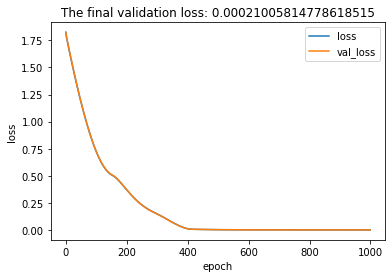

In [0]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

#The plot of true and predicted sin waves look nearly identical

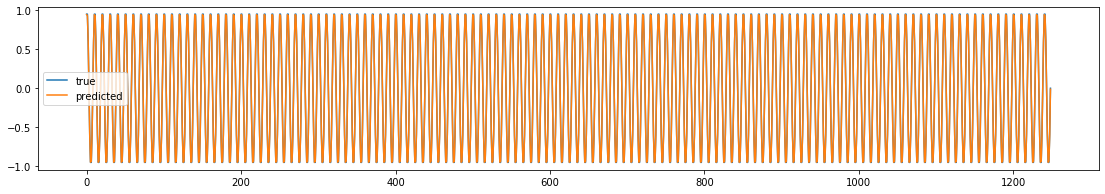

In [0]:
y_pred = model.predict(X_test)
plt.figure(figsize=(19,3))

plt.plot(y_test,label="true")
plt.plot(y_pred,label="predicted")
plt.legend()
plt.show()

#What are the model weights?

The best way to understand the RNN model is to create a model from scratch. Let's extract the weights and try to reproduce the predicted values from the model by hands. The model weights can be readily obtained from the model.layers.

In [0]:
ws = {}
for layer in model.layers:
    ws[layer.name] = layer.get_weights()
ws

{'RNN': [array([[-0.43695387]], dtype=float32),
  array([[-0.64668506]], dtype=float32),
  array([0.00117508], dtype=float32)],
 'dense': [array([[-3.7658346]], dtype=float32),
  array([-0.00123706], dtype=float32)],
 'input_1': []}

#What are the predicted values of hidden units?

Since we used Keras's functional API to develop a model, we can easily see the output of each layer by compiling another model with outputs specified to be the layer of interest.

In order to use the .predict() function, we need to compile the model, which requires specifying loss and optimizer. You can choose any values of loss and optimizer here, as we do not actually optimize this loss function. The newly created model "rnn_model" shares the weights obtained by the previous model's optimization. Therefore for the purpose of visualizing the hidden unit values with the current model result, we do not need to do additional optimizations.

In [0]:
rnn_model = Model(inputs=[inp],outputs=[rnn])
rnn_model.compile(loss="mean_squared_error", optimizer="rmsprop")
hidden_units = rnn_model.predict(X_test).flatten()

Plot shows that the predicted hidden unit is capturing the wave shape. Scaling and shifting of the predicted hidden unit yield the predicted sin wave.

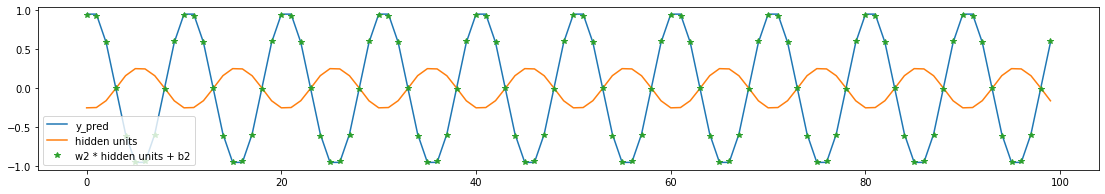

In [0]:
upto = 100
predicted_sin_wave = ws["dense"][0][0][0]*hidden_units + ws["dense"][1][0]

plt.figure(figsize=(19,3))
plt.plot(y_test[:upto],label="y_pred")
plt.plot(hidden_units[:upto],label="hidden units")
plt.plot(predicted_sin_wave[:upto],"*",
         label="w2 * hidden units + b2")
plt.legend()
plt.show()

#Obtain predicted sin wave at the next time point given the current sin wave by hand

We understand that how the predicted sin wave values can be obtained using the predicted hidden states from Keras. But how does the predicted hidden states generated from the original inputs i.e. the current sin wave? Here, stateful and stateless prediction comes into very important role. Following the definition of the RNN, we can write a script for RNNmodel as:

In [0]:
def RNNmodel(ws,x,h=0):
    '''
    ws: predicted weights 
    x : scalar current sign value
    h : scalar RNN hidden unit 
    '''
           
    h = np.tanh(x*ws["RNN"][0][0][0] + h*ws["RNN"][1][0][0] + ws["RNN"][2][0])
    x = h*ws["dense"][0][0][0] + ws["dense"][1][0]
    
    return(x,h)

Naturally, you can obtain the predicted sin waves $(x_1,x_2,...,x_t)$ by looping around RNNmodel as:

$x^∗_{t+1},h_{t+1} = $ RNNmodel$(x_t,h_t)$

Here $x^∗_t$ indicates the estimated value of $x$ at time point $t$. As our model is not so complicated, we can readily implement this algorithm as:

In [0]:
upto = 50 ## predict the first  sin values
xstars, hs_hand = [], []
for i, x in enumerate(df_test.values):
    if i == 0:
        h = 0 ## initial hidden layer value is zero
        xstar = x
        print("initial value of sin x_0 = {}, h_0 = {}".format(x,h))
    hs_hand.append(h)
    xstars.append(xstar[0])
    xstar, h = RNNmodel(ws,x, h)

assert len(df_test.values) == len(xstars)

initial value of sin x_0 = [-1.27375647e-13], h_0 = 0


In this formulation, x_stars[t] contains the prediction of sin wave at time point t just as df_test

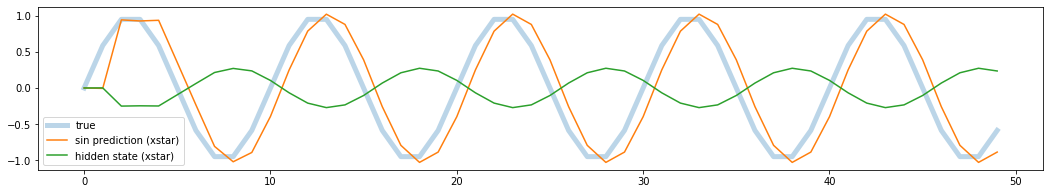

In [0]:
plt.figure(figsize=(18,3))
plt.plot(df_test.values[:upto],label="true",alpha=0.3,linewidth=5)
plt.plot(xstars[:upto],label="sin prediction (xstar)")
plt.plot(hs_hand[:upto],label="hidden state (xstar)")
plt.legend()

You can see that the model prediction is not good in the first few time points and then stabilized. OK. My model seems to over estimates the values when sin wave is going down and underestimates when the sin wave is going up. However, there is one question: this model returns almost zero validation loss. The error seems a bit high. In fact the error from the prediction above is quite large. What is going on?

In [0]:
"validation loss {:3.2f}".format(np.mean((np.array(xstars) - df_test["sin_t"].values)**2))

'validation loss 0.08'

Let's predict the sin wave using the existing predict function from Keras. Remind you that we prepare X_test when X_train was defined. X_test contains data as:

x1,x2x2,x3x3,x4...

In [0]:
y_test_from_keras = model.predict(X_test).flatten()

Notice that this predicted values are exactly the same as the ones calculated before.

In [0]:
np.all(predicted_sin_wave == y_test_from_keras)

True

As the prediction starts from x_3, add the 2 NaN into a predicted vector as placeholders. This is just to make sure that the length of y_test_from_keras is compatible with xtars.

In [0]:
y_test_from_keras = [np.NaN, np.NaN] + list(y_test_from_keras.flatten())
h_test_from_keras = [np.NaN, np.NaN] + list(hidden_units.flatten())

The plot shows that Keras's predicted values are almost perfect and the validation loss is nearly zero. Clearly xstars are different from the Keras's prediction. It seems that the predicted states from Keras and from by hand are also slightly different. Then question is, how does Keras predict the output?

validation loss 0.00021


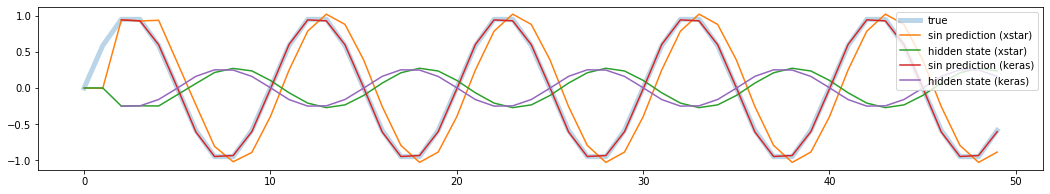

In [0]:
plt.figure(figsize=(18,3))
plt.plot(df_test.values[:upto],label="true",alpha=0.3,linewidth=5)
plt.plot(xstars[:upto],label="sin prediction (xstar)")
plt.plot(hs_hand[:upto],label="hidden state (xstar)")
plt.plot(y_test_from_keras[:upto],label="sin prediction (keras)")
plt.plot(h_test_from_keras[:upto],label="hidden state (keras)")
plt.legend()

print("validation loss {:6.5f}".format(np.nanmean((np.array(y_test_from_keras) - df_test["sin_t"].values)**2)))

Here, the technical details of the BPTT algorithm comes in, and the time series length parameter (i.e., batch_size[1]) takes very important role.

As the BPTT algorithm only passed back 2 steps, the model assumes that:

the hidden units are initialized to zero every 2 steps.
the prediction of the next sin value (xt+1) is based on the hidden unit (ht) which is created by updating the hidden units twice in the past assuming that ht−1=0.
x∗t,ht=RNNmodel(xt−1,0)xt+1,−=RNNmodel(xt,ht)
Note that the intermediate predicted sin x∗t based on ht−1=0 should not be used as the predicted sin value. This is because the x∗t was not directly used to evaluate the loss function.

Finally, obtain the Keras's predicted sin wave at the next time point given the current sin wave by hand.

In [0]:
def myRNNpredict(ws,X):
    X = X.flatten()
    h = 0
    for i in range(len(X)):
        x,h = RNNmodel(ws,X[i],h)
    return(x,h)


xs, hs = [], []
for i in range(X_test.shape[0]):
    x, h = myRNNpredict(ws,X_test[i,:,:])
    xs.append(x)
    hs.append(h)

In [0]:
print("All sin estimates agree with ones from Keras = {}".format(
    np.all(np.abs( np.array(xs) - np.array(y_test_from_keras[2:]) ) < 1E-5)))

print("All hidden state estmiates agree with ones fome Keras = {}".format(
    np.all(np.abs( np.array(hs) - np.array(h_test_from_keras[2:]) ) < 1E-5)) )

All sin estimates agree with ones from Keras = True
All hidden state estmiates agree with ones fome Keras = True


Now we understand how Keras is predicting the sin wave.

In fact, Keras has a way to return xstar as predicted values, using "stateful" flag. This stateful is a notorious parameter and many people seem to be very confused. But by now you can understand what this stateful flag is doing, at least during the prediction phase. When stateful = True, you can decide when to reset the states to 0 by yourself.

In order to predict in "stateful" mode, we need to re-define the model with stateful = True. When stateful is True, we need to specify the exact integer for batch_size. As we only have a single sin time series, we will set the batch_size to 1.

In [0]:
model_stateful,_ = define_model(length_of_sequences = 1, 
                              batch_size=1, 
                              stateful = True)
model_stateful.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (1, 1, 1)                 0         
_________________________________________________________________
RNN (SimpleRNN)              (1, 1)                    3         
_________________________________________________________________
dense (Dense)                (1, 1)                    2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


Assign the trained weights into the stateful model.

In [0]:
for layer in model.layers:        
    for layer_predict in model_stateful.layers:
        if (layer_predict.name == layer.name):
            layer_predict.set_weights(layer.get_weights())
            break

Now we predict in stateful mode. Here it is very important to reset_state() before the prediction so that h0=0.

In [0]:
pred = df_test.values[0][0]
stateful_sin = []
model_stateful.reset_states()
for i in range(df_test.shape[0]):
    stateful_sin.append(pred)
    pred = model_stateful.predict(df_test.values[i].reshape(1,1,1))[0][0]
    
stateful_sin = np.array(stateful_sin)


In [0]:
print("All predicted sin values with stateful model agree to xstars = {}".format(
    np.all(np.abs(np.array(stateful_sin) - np.array(xstars))< 1E-5)))

All predicted sin values with stateful model agree to xstars = True


Now we understand that xstars is the prediction result when stateful = True. We also understand that the prediction results are way better when stateful = False at least for this sin wave example.

However, the prediction with stateful = False brings to some awkwardness: what if our batch have a very long time series of length, say K? Do we always have to go back all the K time steps, set ht−K=0 and then feed forward K steps in order to predict at the time point t? This may be computationally intense.